# Bonus1: Parallel Algorithms

### Name: Michael Eng


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.02731399 -0.07612859 -0.08180088 -0.18243332  0.03285738 -0.15035012
  -0.04080219  0.02343434]]
test std = 
[[0.9858857  0.99667376 1.07689614 0.93742428 1.239963   1.21929535
  1.06460598 1.04239512]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [5]:
class Worker:
    def __init__(self, x, y, batch_size=-1, q=1):
        self.x = x # s-by-d local feature matrix
        self.y = y # s-by-1 local label matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features
        self.w = numpy.zeros((d,1)) # d-by-1 model parameter vector
        self.q = q
        if batch_size == -1:
            self.bs = self.s
        else:
            self.bs = batch_size
        
    def set_param(self, w):
        self.w = w
        
    # Compute local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d matrix
        yxw = numpy.dot(yx, self.w) # s-by-1 matrix
        vec1 = numpy.exp(-yxw) # s-by-1 matrix
        vec2 = numpy.log(1 + vec1) # s-by-1 matrix
        return numpy.sum(vec2) # loss function
    
    # Compute local gradient
    def gradient(self): 
        batches = int(self.s / self.bs)
        g = 0
        for _ in range(self.q):
            for batch_number in range(0, batches):
                batch = range(batch_number * self.bs, (batch_number + 1) * self.bs)
                yx = numpy.multiply(self.y[batch], self.x[batch]) # s-by-d matrix
                yxw = numpy.dot(yx, self.w) #s-by-1
                vec1 = numpy.exp(yxw) # s-by-1 matrix
                vec2 = numpy.divide(yx,1+vec1) # s-by-d matrix
                g = g - numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
            g /= batches
        
        return g

In [6]:
class Server:
    def __init__(self, m, n, d):
        self.m = m # number of worker nodes
        self.n = n # number of training samples
        self.d = d # number of features
        self.w = numpy.zeros((d, 1)) # d-by-1 model parameter vector
        self.g = numpy.zeros((d, 1)) # d-by-1 gradient
        self.v = numpy.zeros((d, 1)) # d-by-1 momentum
        self.los = 0 # loss function value
        self.obj = 0 # objective function value
        
    def broadcast(self):
        return self.w
    
    # Sum gradients and loss functions evaluated by workers
    # Args:
    #   grads: a list of d-by-1 vectors
    #   losses: a list of scalars
    def aggregate(self, grads, losses):
        self.g = numpy.zeros((self.d, 1))
        self.loss = 0
        for k in range(self.m):
            self.g += grads[k]
            self.loss += losses[k]
            
    # Compute gradient  (from the loss and regularization)
    def gradient(self, lam):
        self.g = self.g / self.n + lam * self.w
        
    # Compute the objective function (sum of loss and regularization)
    def objective(self, lam):
        reg = lam / 2 * numpy.sum(self.w * self.w)
        self.obj = self.loss / self.n + reg
        return self.obj
    
    # Update the model parameters using accelerated gradient descent
    # Args:
    #     alpha: learning rate (step size)
    #     beta: momentum parameter
    def agd(self, alpha, beta):
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v
        
        


In [7]:
import math

# Create a server and m worker nodes
def create_server_workers(m, x, y, batch_size, q):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d)
    workers = []
    
    
    for i in range(m):
        indices = list(range(i*s, (i + 1) * s))
        worker = Worker(x[indices, :], y[indices, :], batch_size=batch_size, q=q)
        workers.append(worker)
        
    return server, workers

In [8]:
m = 4 # num of worker nodes
serv_work = []

# list of tuples. The first element is batch amount, second is q level
arguments=[(-1, 1), (-1,8), (1, 1), (1,8)]

for batch_size, q in arguments:
#     batch_size = arguments[i][0]
#     q = arguments[i][1]
    server, workers = create_server_workers(m, x_train, y_train, batch_size, q)
    serv_work.append((server, workers))


In [9]:
lam = 1E-6 # regularization parameter
alpha = 1E-1 # learning rate
beta = 0.9 # momentum parameter
max_epoch = 50

results = []
for server, worker in serv_work:
    obj_total = []
    for t in range(max_epoch):
        # step 1: broadcast
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)

        # step 2: workers' local computations
        grads = []
        losses = []
        for i in range (m):
            g = workers[i].gradient()
            grads.append(g)
            l = workers[i].loss()
            losses.append(l)

        # step 3: aggregate the workers' outputs
        server.aggregate(grads, losses)

        # step 4: server update the model parameters
        server.gradient(lam) # compute gradient
        obj = server.objective(lam) # compute objective function
        #print('Objective function value = ' + str(obj))
        server.agd(alpha, beta) # updates the model parameters
        obj_total.append(obj)
    results.append(obj_total)
        

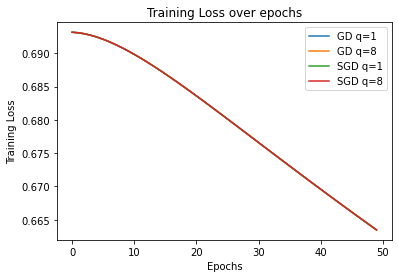

In [12]:
import matplotlib.pyplot as plt

for i, result in enumerate(results):
    if arguments[i][0] == 1:
        label = 'SGD q='
    else:
        label = 'GD q='
    label += str(arguments[i][1])
    plt.plot(range(max_epoch), result, label=label)
plt.title('Training Loss over epochs')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

The training loss for each trial is the exact same even though the changes I made should have different results. I will try to figure this out after the deadline.